# Reconstruction of DOSY NMR signals

# Part I

## Introduction

The relation between $y$ and $t$ can be expressed as the following Laplace transform
$$(\forall m \in \{1,...,M\}) \hspace{1cm} y^{(m)} = \int \chi(T)\exp(-t^{(m)}T)\text dT$$ 
where $\chi(T)$ is the unknown diffusion distribution.

The approximation model reads $$y = K\bar x + w$$ where $K \in \mathbb R^{M\times N}$ is given by $$(\forall m \in \{1,...,M\})(\forall n \in \{1,...,N\}) \hspace{1cm} K^{(m,n)} = \exp(-T^{(n)}t^{(m)})$$

We want to solve the following minimization problem
$$ \hat x = \mathbf{argmin}_{x\in\mathbb R^N} \dfrac12 ||Kx-y||^2 + \beta g(x)$$

## Generation of synthetic data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
signal = pd.read_csv('./signal.csv')
signal

,data
0,2.044046e-15
1,9.534637e-15
2,4.273128e-14
3,1.839992e-13
4,7.612267e-13
...,...
195,2.262232e-22
196,8.618724e-23
197,3.250917e-23
198,1.214020e-23


In [3]:
Tmin = 1
Tmax = 1000
N = len(signal)
T = [Tmin*np.exp(-(n-1)*np.log(Tmin/Tmax)/(N-1)) for n in range(1,N+1)]

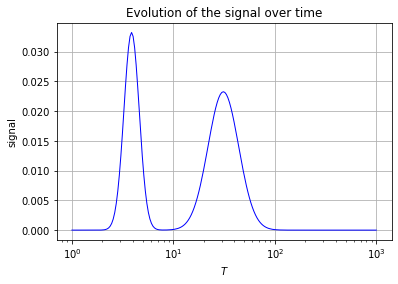

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(T, signal, color='blue', lw=1)

ax.set_xscale('log')
plt.xlabel('$T$')
plt.ylabel('signal')
plt.title('Evolution of the signal over time')
plt.grid()
plt.show()

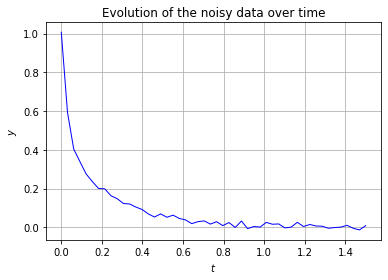

In [5]:
M = 50
tmin = 0
tmax = 1.5
t = [tmin + (m-1)/(M-1)*(tmax-tmin) for m in range(1,M+1)]

K = np.zeros((M,N))
for m in range(M):
    for n in range(N):
        K[m][n] = np.exp(-T[n]*t[m])
        
z = np.array(K@signal)
sigma = 0.01*z[0]
w = sigma * np.random.randn(M,1)

y = z+w.reshape((M,1))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line = ax.plot(t, y, color='blue', lw=1)

plt.title('Evolution of the noisy data over time')
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.grid()

## Comparison of regularization strategies

### Smoothness prior

We can express $(4)$ as $$\hat x = \mathbf{argmin }_{x\in\mathbb R^N} f(x) := \dfrac12 ||Kx- y||^2 + \beta \dfrac12||Dx||^2$$ where $D \in \mathbb R^{N\times N}$ is the discrete gradient operator.

We can calculate the gradient of $f$, and the hessian, this yields

- $\nabla f(x) = (Kx - y)^TK + \beta(Dx)^TD = K^TKx -K^Ty + \beta D^TDx $
- $\nabla^2f(x) = K^TK + \beta D^TD$

Hence $\nabla f(\hat  x) = 0 \iff \hat x = (K^TK + \beta D^TD)^{-1}K^Ty$. Indeed, $(K^TK + \beta D^TD)^{-1}K^Ty$ is invertible because it is SDP.

In [6]:
D = (np.eye(N)-np.eye(N, k=-1))
D[0][-1] = -1
print(D)

[[ 1.  0.  0. ...  0.  0. -1.]
 [-1.  1.  0. ...  0.  0.  0.]
 [ 0. -1.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ... -1.  1.  0.]
 [ 0.  0.  0. ...  0. -1.  1.]]


In [7]:
def reconstruct(beta):
    from numpy.linalg import inv
    return inv(K.T@K + beta*D.T@D)@K.T@y

def error(beta):
    xhat = reconstruct(beta)
    xbar = np.array(signal)
    return (np.square(xhat - xbar)).mean(axis=None)

def finetuning(error_func, bg=1e-10, eg=1e-3):
    grid = np.linspace(bg, eg, 100)
    res = []
    for beta in grid:
        res.append(error_func(beta=beta))
    beta_min = grid[np.argmin(res)]
    beta_max = grid[np.argmax(res)]
    return beta_min, beta_max

In [8]:
#finetuning(error)
#(0.001, 1e-10)

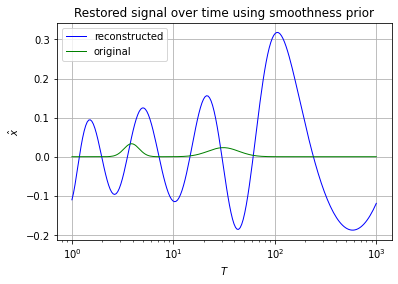

0.019210447029926667 1081548737.6513698


In [9]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(T, reconstruct(1e-3), color='blue', label="reconstructed", lw=1)
# line, = ax.plot(T, reconstruct(1e-10), color='red', label="worst reconstructed", lw=1)
line, = ax.plot(T, signal, color='green', label="original", lw=1)

ax.set_xscale('log')
plt.title('Restored signal over time using smoothness prior')
plt.xlabel('$T$')
plt.ylabel('$\hat x$')
plt.grid()
plt.legend()
plt.show()

print(error(1e-3), error(1e-10))

We can observe that the results are rather **bad**: the reconstructed signal gets really far from the original one as $T$ goes to infinity, hence the necessity to implement other algorithms.

### Smoothness prior + constraints

We can express $(4)$ as $$\hat x = \mathbf{argmin }_{x\in\mathbb R^N} f(x) := \dfrac12 ||Kx- y||^2 + \beta \left(\dfrac12||Dx||^2 + \iota_{[x_{min}, x_{max}]N}(x)\right)$$ where $D \in \mathbb R^{N\times N}$ is the discrete gradient operator, and $0 < x_{min} < x_{max}$ the minimum and maximum values of the original signal $\bar x$.

The above expression is equivalent to $$\hat x = \mathbf{argmin }_{x\in [x_{min},x_{max}]} f(x) := \dfrac12 ||Kx- y||^2 + \beta \dfrac12||Dx||^2$$

- The compacts of $\mathbb R$ are the intervals, therefore $[x_{min}, x_{max}]$ is a compact set. In addition, $f$ is continuous and strictly convex on $[x_{min}, x_{max}]$, hence the solution to the above problem is **unique**.
- $f$ is proper, convex and l.s.c, so $f\in\Gamma_0(\mathbb R^N)$.
- $f$ is differentiable and, for $x_1, x_2 \in [x_{min}, x_{max}]$, 
    $$||\nabla f(x_1) - \nabla f(x_2) || = ||(Kx_1 - y)^TK + \beta(Dx_1)^TD - (Kx_2 - y)^TK - \beta(Dx_2)^TD||
    =||\left(K^TK+\beta D^TD\right)(x_1-x_2)|| \le \underbrace{||K^TK+\beta D^TD||}_{\nu}\cdot||x_1-x_2||$$ so $f$ is gradient-Lipschitz.

In conclusion, we can apply the **projected gradient algorithm** :

$$(\forall n \in \mathbb N) \hspace{1cm} \left\{
    \begin{array}{ll}
        y_n = x_n - \gamma\left(K^TKx_n -K^Ty + \beta D^TDx_n\right)   \\
        x_{n+1} = x_n + \lambda_n\left(P_{[x_{min}, x_{max}]}y_n - x_n\right)
    \end{array}
\right.$$
such that $\gamma \in ]0,2/\nu[$. Then $(x_n)_{n\in\mathbb N} \longrightarrow \hat x$.

For simplicity, we set for all $n\in\mathbb N$, $\lambda_n = \lambda \in [0, 2 - \gamma\nu/2]$.

Finally, projecting a point on a line is pretty straightforward: we just have to consider the case where the point in smaller than the lower bound, the case where the point in on the line, and the case where the point is greater than the upper bound.

In [10]:
def proj_grad(v):
    xmin = signal.values.min()
    xmax = signal.values.max()
    for k in range(len(v)):
        if v[k] < xmin:
            v[k] = xmin
        elif v[k] > xmax:
            v[k] = xmax
    return v

def max_evalue(M):
    from numpy import linalg
    return (linalg.eig(M)[0]).max()

def reconstruct_spc(beta, max_iter=10000):
    xmin = signal.values.min()
    xmax = signal.values.max()
    x0 = np.reshape([0.5*(xmin+xmax) for i in range(len(signal))], (N,1))
    x = [x0]
    aux = []
    nu = max_evalue(K.T@K + beta*D.T@D)
    gamma = 0.9*2/nu
    lamb = 1
    for k in range(max_iter):
        aux.append(x[k] - gamma * (K.T@K@x[k] - K.T@y + beta * D.T@D@x[k]))
        x.append(x[k] + lamb * (proj_grad(aux[k]) - x[k]))
    return x[-1]

def error_spc(beta):
    xhat = reconstruct_spc(beta, max_iter=5000)
    xbar = np.array(signal)
    return (np.square(xhat - xbar)).mean(axis=None)

In [11]:
#finetuning(error_spc)
#(1e-10, 0.001)

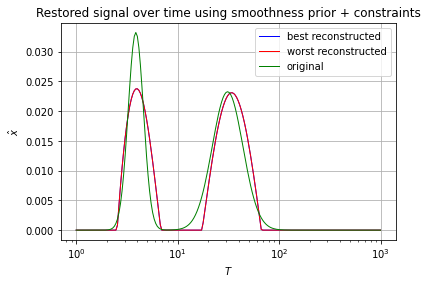

9.492706638400561e-06 9.49195326503704e-06


In [12]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(T, reconstruct_spc(1e-3), color='blue', label="best reconstructed", lw=1)
line, = ax.plot(T, reconstruct_spc(1e-10), color='red', label="worst reconstructed", lw=1)
line, = ax.plot(T, signal, color='green', label="original", lw=1)

ax.set_xscale('log')
plt.title('Restored signal over time using smoothness prior + constraints')
plt.xlabel('$T$')
plt.ylabel('$\hat x$')
plt.grid()
plt.legend()
plt.show()

print(error_spc(1e-3), error_spc(1e-10))

This time we get much better results, plus the best reconstructed signal and the worst reconstructed signal (for the grid we considered) are pretty close from eachother, meaning the algorithm is stable in $\beta$.

### Sparsity prior

We can express $(4)$ as $$\hat x = \mathbf{argmin }_{x\in\mathbb R^N} f(x) := \dfrac12 ||Kx- y||^2 + \beta ||x||_1$$

$f$ is continuous on $\mathbb R^N$, we have for all $x\in\mathbb R^N$ $$\displaystyle f(x) \ge \dfrac12||Kx-y||^2 + C||x|| \to_{||x|| \to +\infty} +\infty$$ where $C$ is a constant that commes from the equivalence of norms in finite dimension. Hence $f$ is coercive. Therefore there exists **at least one** minimizer to the above problem.

- $f_1 : x \mapsto \dfrac12 ||Kx-y||^2$ is proper, convex and l.s.c so $f_1 \in \Gamma_0(\mathbb R^N)$.
- Similarly, $f_2 : x \mapsto \beta ||x||_1$ is proper, convex and l.s.c so $f_2 \in \Gamma_0(\mathbb R^N)$.
- $f_1$ is differentiable and, for $x_1, x_2 \in \mathbb R^N$, 
    $$||\nabla f_1(x_1) - \nabla f_1(x_2) || = ||(Kx_1 - y)^TK - (Kx_2 - y)^TK||
    =||\left(K^TK\right)(x_1-x_2)|| \le \underbrace{||K^TK||}_{\nu}\cdot||x_1-x_2||$$ so $f_1$ is gradient-Lipschitz.

In conclusion, we can apply the **forward-backward algorithm** :

$$(\forall n \in \mathbb N) \hspace{1cm} \left\{
    \begin{array}{ll}
        y_n = x_n - \gamma\left(K^TKx_n - K^Ty\right)   \\
        x_{n+1} = x_n + \lambda\left(prox_{\gamma f_2}(y_n) - x_n\right)
    \end{array}
\right.$$
such that $\gamma \in ]0,2/\nu[$, and $\lambda \in [0, 2 - \gamma\nu/2]$. Then $(x_n)_{n\in\mathbb N} \longrightarrow \hat x$.

In addition, $prox_{\gamma f_2} (y) = (\mathbf{sgn}(y_i)\mathbf{max}\{0, |y_i| - \gamma \beta\})_{i=1,...,N}$.

In [13]:
def prox(v, gamma, beta):
    return np.sign(v) * np.maximum(np.abs(v) - gamma*beta, 0)

def reconstruct_sp(beta, max_iter=10000):
    aux = []
    xmin = signal.values.min()
    xmax = signal.values.max()
    x0 = np.reshape([0.5*(xmin+xmax) for i in range(len(signal))], (N,1))
    x = [x0]
    nu = np.real(max_evalue(K.T@K))
    gamma = 0.9*2/nu
    lamb = 1
    for k in range(max_iter):
        aux.append(x[k] - gamma * K.T@(K@x[k] - y))
        x.append(x[k] + lamb*(prox(aux[k], gamma, beta) - x[k]))
    return x[-1]

def error_sp(beta):
    xhat = reconstruct_sp(beta)
    xbar = np.array(signal)
    return (np.square(xhat - xbar)).mean(axis=None)

In [14]:
# finetuning(error_sp)
# (1e-10, 0.00012121220909090907)

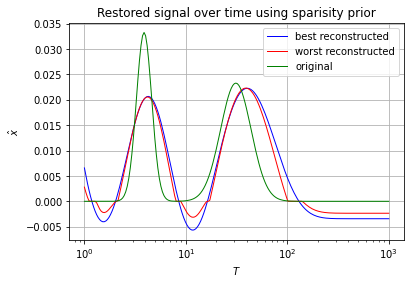

3.5258535929861525e-05 2.4999292562703155e-05


In [15]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(T, reconstruct_sp(1e-10, max_iter=10000), color='blue', label="best reconstructed", lw=1)
line, = ax.plot(T, reconstruct_sp(1e-4, max_iter=10000), color='red', label="worst reconstructed", lw=1)
line, = ax.plot(T, signal, color='green', label="original", lw=1)

ax.set_xscale('log')
plt.title('Restored signal over time using sparisity prior')
plt.xlabel('$T$')
plt.ylabel('$\hat x$')
plt.grid()
plt.legend()
plt.show()

print(error_sp(1e-10), error_sp(1e-4))

Sparsity prior has also good results, but not as good as the smoothness prior with constraints. Hence if we want to improve our results, we know that we have to consider a forward-backward algorithm like approach.

# Part II

## Maximum entropy regularization

We now want to solve 
$$ \hat x = \mathbf{argmin}_{x\in\mathbb R^N} f(x) :=\dfrac12 ||Kx-y||^2 + \beta ent(x)$$ 
where 
$$(\forall x \in \mathbb R^N) \hspace{1cm} ent(x) = \sum_{i=1}^N\varphi(x_i)$$ 
with 
$$(\forall u \in \mathbb R) \hspace{1cm} \varphi(u) = \left\{
    \begin{array}{ll}
       u\log u & \text{if } u > 0, \\
       0 & \text{if } u = 0,\\
       +\infty & \text{elsewhere.}
    \end{array}
\right.$$

1. - Consider the vector $v=(0,...,0)\in\mathbb R^N$, we have $\displaystyle ent(v) = \sum_{i=1}^N \varphi(0) = 0$. Therefore $ent$ is **proper**.
  - Consider now a sequence $x^{(n)} = (x_1^{(n)},...,x_N^{(n)})$ such that $x^{(n)} \to_{n\to+\infty} x = (x_1,...,x_N) \in \mathbb R^N$. As $\varphi$ is proper, it is l.s.c, therefore for all $1 \le i \le N$, $\lim_{n\to+\infty}\inf \varphi(x_i^{(n)}) \ge \varphi(x_i).$ By summation, we have $$\sum_{i=1}^N \lim_{n\to+\infty}\inf \varphi(x_i^{(n)}) \ge \sum_{i=1}^N \varphi(x_i) = ent(x)$$
Hence, $$\lim_{n\to+\infty}\inf ent(x^{(n)}) = \lim_{n\to+\infty}\inf \sum_{i=1}^N\varphi(x_i^{(n)}) \ge \sum_{i=1}^N \lim_{n\to+\infty}\inf \varphi(x_i^{(n)}) \ge ent(x)$$
Therefore $ent$ is **lower semicontinuous**.
   - For $u\in\mathbb R_+^*$, $\varphi'(u) = 1 + \log u$, $\varphi''(u) = \dfrac1u > 0$. Therefore $\varphi$ is strictly convex on $\mathbb R_+^*$. In addition, $\lim_{u\to0} \varphi(u) = 0 = \varphi(0)$.
Consider $x, y \in \mathbb R_-$, for $0\le t \le 1$, denote $z=tx+(1-t)y \in \mathbb R_-$. We have (for $z \neq 0$)
$$\varphi(z) = +\infty \le t\underbrace{\varphi(x)}_{=+\infty} + (1-t)\underbrace{\varphi(y)}_{=+\infty} = +\infty$$
For $z=0$, necessarily $x=0$ and $y=0$, and $\varphi(0) \le t\cdot0+(1-t)\cdot0 = 0$. Hence $\varphi$ is strictly convex on all $\mathbb R$. $ent$ is the positive sum of strictly convex functions, therefore $ent$ is **strictly convex** on $\mathbb R^N$.

2. $\varphi$ is coercive so it follows that $ent$ is also coercive. The quadratic term of $f$ is also coercive, therefore $f$ is **coercive** which means the problem has at least one solution. Also, the quadratic term is strictly convex on $\mathbb R$, so $f$ is **strictly convex** as a positive sum of strictly convex functions on $\mathbb R$. All in all, **the problem has a unique solution**.

3. First, we have that $prox_{\gamma\beta ent}(v) = \left(prox_{\gamma\beta \varphi}(v_i)\right)_{1\le i \le N}$ and for $1 \le i \le N$,
$$prox_{\gamma\beta \varphi}(v_i) = \mathbf{argmin}_{y\in\mathbb R^N}~ \gamma\beta y\log y + \dfrac12 ||y-v_i||^2$$
Define $g:y\mapsto \gamma\beta y\log y + \dfrac12||y-v_i||^2$. $g$ is differentiable: we have $g':y \mapsto \gamma\beta + \gamma\beta\log y + y - v_i$. Then
$$g'(y) = 0 \iff \dfrac{y}{\gamma\beta} + \log y = \dfrac{v_i}{\gamma\beta} - 1 \iff \dfrac{y}{\gamma\beta}e^{\frac{y}{\gamma\beta}} = e^{\frac{v_i}{\gamma\beta} - 1  - \log \gamma\beta}$$
Hence, 
$$\dfrac{y}{\gamma\beta} = W\left(e^{\frac{v_i}{\gamma\beta} - 1 - \log\gamma\beta}\right)$$ 
which yields
$$prox_{\gamma\beta\varphi}(v_i) = \gamma\beta W\left(e^{\frac{v_i}{\gamma\beta} - 1 - \log\gamma\beta}\right)$$
and ultimately
$$prox_{\gamma\beta ent}(v) = \left(\gamma\beta W\left(e^{\frac{v_i}{\gamma\beta} - 1 - \log\gamma\beta}\right)\right)_{1\le i \le N} $$

4. Recall the **forward-backward** algorithm:

$$(\forall n \in \mathbb N) \hspace{1cm} \left\{
    \begin{array}{ll}
        y_n = x_n - \gamma\left(K^TKx_n - K^Ty\right)   \\
        x_{n+1} = x_n + \lambda\left(prox_{\gamma \beta ent}(y_n) - x_n\right)
    \end{array}
\right.$$
such that $\gamma \in ]0,2/\nu[$, and $\lambda \in [0, 2 - \gamma\nu/2]$. Then $(x_n)_{n\in\mathbb N} \longrightarrow \hat x$.

5. For the **Douglas-Rachford** algorithm, we need to compute the prox of the quadratic term:
$$prox_{\frac\gamma 2||K\cdot - y||^2}(v) = \mathbf{argmin}_{u\in\mathbb R^N} ~ \dfrac{\gamma}{2} ||Ku-y||^2 + \dfrac12 ||u-v||^2$$
    
Differentiating gives 
$$prox_{\frac\gamma 2||K\cdot - y||^2}(v) = \left(\gamma K^TK + Id\right)^{-1}\left(v + \gamma K^Ty\right)$$
Hence, the **Douglas-Rachford** algorithm is:
$$(\forall n \in \mathbb N) \hspace{1cm} \left\{
    \begin{array}{ll}
        y_n = prox_{\gamma\beta ent}(x_n) \\
        z_n = prox_{\frac\gamma2||K\cdot - y||^2}(2y_n - x_n) \\
        x_{n+1} = x_n + \lambda(z_n-x_n)
    \end{array}
\right.$$
such that $\gamma\in]0,+\infty[$ and $\lambda\in]0,2[$.

In [16]:
from numpy.linalg import inv
from math import *
beta = 1e-3

def lambert_o_exp(z):
    if z > 100 :
        return z - log(z)        
    if z < -20 :
        return 0
    w = 1
    v = float("inf")
    x = exp(z)
    while abs(w-v)/abs(w)>1e-8:
        v = w
        e = exp(w)
        f = w*e - x 
        w = w - f/((e*(w+1) - (w+2)*f/(2*w+2)))
    return w

lambert_vec = np.vectorize(lambert_o_exp)


def prox_ent(v, gamma, beta):
    return gamma*beta*lambert_vec(v/(gamma*beta) - 1 - np.log(gamma*beta))

def prox_quad(v, gamma, beta):
    return inv(gamma*K.T@K + np.eye(N))@(v + gamma*K.T@y)
    
def reconstruct_fb(beta, max_iter=5000):
    aux = []
    xmin = signal.values.min()
    xmax = signal.values.max()
    x0 = np.reshape([0.5*(xmin+xmax) for i in range(len(signal))], (N,1))
    x = [x0]
    nu = np.real(max_evalue(K.T@K))
    gamma = 0.9*2/nu
    lamb = 1
    for k in range(max_iter):
        aux.append(x[k] - gamma * K.T@(K@x[k] - y))
        x.append(x[k] + lamb*(prox_ent(aux[k], gamma, beta) - x[k]))
    return x[-1]

def error_fb(beta):
    xhat = reconstruct_fb(beta)
    xbar = np.array(signal)
    return (np.square(xhat - xbar)).mean(axis=None)

def reconstruct_dr(beta, max_iter=20):
    aux = []
    z = []
    xmin = signal.values.min()
    xmax = signal.values.max()
    x0 = np.reshape([0.5*(xmin+xmax) for i in range(len(signal))], (N,1))
    x = [x0]
    nu = np.real(max_evalue(K.T@K))
    gamma = 0.9*2/nu
    lamb = 0.9*(2-gamma*nu/2)
    for k in range(max_iter):
        aux.append(prox_ent(x[k], gamma, beta))
        z.append(prox_quad(2*np.array(aux[k]) - x[k], gamma, beta))
        x.append(x[k] + lamb*(z[k] - x[k]))
    return x[-1]

def error_dr(beta):
    xhat = reconstruct_dr(beta)
    xbar = np.array(signal)
    return (np.square(xhat - xbar)).mean(axis=None)

In [17]:
#finetuning(error_fb)
#1e-10

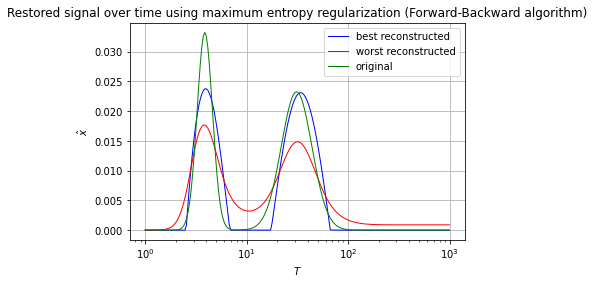

9.491953815934239e-06 1.7777630092936485e-05


In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(T, reconstruct_fb(1e-10, max_iter=10000), color='blue', label="best reconstructed", lw=1)
line, = ax.plot(T, reconstruct_fb(1e-3, max_iter=10000), color='red', label="worst reconstructed", lw=1)

line, = ax.plot(T, signal, color='green', label="original", lw=1)

ax.set_xscale('log')
plt.title('Restored signal over time using maximum entropy regularization (Forward-Backward algorithm)')
plt.xlabel('$T$')
plt.ylabel('$\hat x$')
plt.grid()
plt.legend()
plt.show()
print(error_fb(1e-10), error_fb(1e-3))

In [19]:
#finetuning(error_dr)
#1e-10

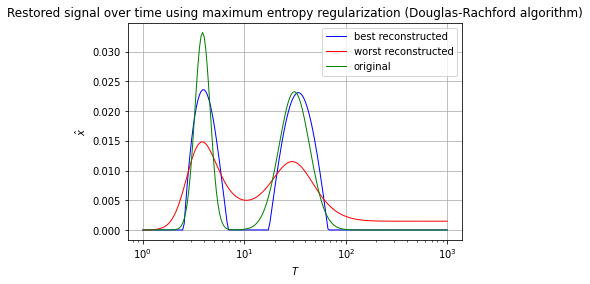

6.033427149280115e-05 6.046495334164049e-05


In [20]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(T, reconstruct_dr(1e-10, max_iter=10000), color='blue', label="best reconstructed", lw=1)
line, = ax.plot(T, reconstruct_dr(1e-3, max_iter=10000), color='red', label="worst reconstructed", lw=1)
line, = ax.plot(T, signal, color='green', label="original", lw=1)

ax.set_xscale('log')
plt.title('Restored signal over time using maximum entropy regularization (Douglas-Rachford algorithm)')
plt.xlabel('$T$')
plt.ylabel('$\hat x$')
plt.grid()
plt.legend()
plt.show()
print(error_dr(1e-10), error_dr(1e-3))

6. The experience shows that the smaller $\beta$, the better results. With a grid going from $10^{-10}$ to $10^{-3}$, the best results were obtained with $\beta \approx 1\cdot10^{-10}$. If we just kept lowering the lower-bound of the grid, the quality would have gotten better and better.

7. The best results were obtained with the last algorithm (*i.e.* **Douglas-Rachford**). It is followed by the **Forward-Backward** algorithm and the **projected-gradient** algorithm (which is just a specific case of the forward-backward algorithm), and finally we have the **smoothness prior** algorithms.

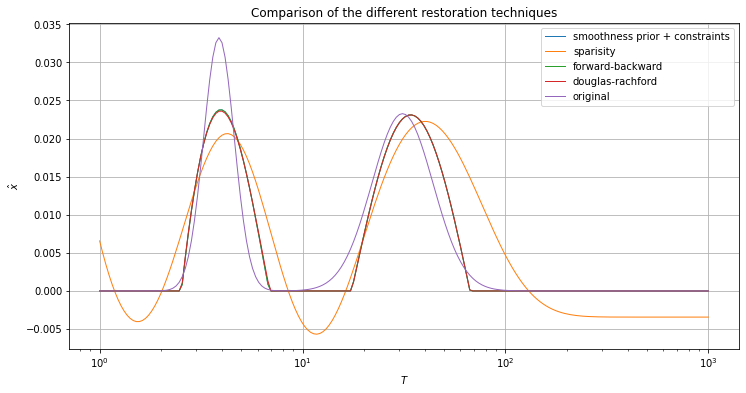

In [21]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1)

#line, = ax.plot(T, reconstruct(1e-3), label="smoothness prior", lw=1)
line, = ax.plot(T, reconstruct_spc(1e-3), label="smoothness prior + constraints", lw=1)
line, = ax.plot(T, reconstruct_sp(1e-10, max_iter=10000), label="sparisity", lw=1)
line, = ax.plot(T, reconstruct_fb(1e-10, max_iter=10000), label="forward-backward", lw=1)
line, = ax.plot(T, reconstruct_dr(1e-10, max_iter=10000), label="douglas-rachford", lw=1)
line, = ax.plot(T, signal, label="original", lw=1)

ax.set_xscale('log')
plt.title('Comparison of the different restoration techniques')
plt.xlabel('$T$')
plt.ylabel('$\hat x$')
plt.grid()
plt.legend(loc='upper right')
plt.show()